In [280]:
from qaoa import QAOA
from qaoa.problems.base_problem import Problem
from qaoa.mixers.base_mixer import Mixer
from qaoa.initialstates import InitialState


In [281]:
import numpy as np
import networkx as nx
import sys

sys.path.append("../")
from plotroutines import *

In this Exercise Notebook we are going to study the performance fo the QAOA on the maximum cut (MAXCUT) combinatorial optimization problem. The problem can stated as follows:

Consider a graph $G=(V,E)$ with nodes V, where $|V|=n$ and edges E with weights $w_{ij}>0,w_{ij}=w_{ji}$ for $(i,j)\in E$. A cut is defined as a partition of the original set V intop two subsets. the cost of this cut is the sum of weights of edges connecting points in the two different subsets. The MAXCUT is the cut that maximize this cost that can be defined as


$C(\vec{x})=\sum_{ij}w_{ij}x_{i}(1-x_{j})$. 

where $x_{i}$ is a binary variable that is 0 if the vertex is in the first partition or 1 if is in the second one.


Finding an exact solution for this problem is NP-hard but some classical algorithms can find an approximate solution in polynomial time like the Goemans-Williamson algorithm that guarantees an approximation ratio $\frac{C}{C_{opt}}=0.8785$.

In [282]:
def generate_connected_graph(n, k=3):
    G = nx.barabasi_albert_graph(n, k)
    for edge in G.edges(data=True):
        edge[2]['weight'] = 1.0
    return G

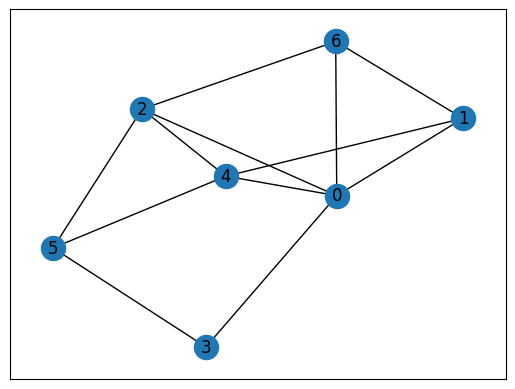

In [283]:
G=generate_connected_graph(7)

pos = nx.spring_layout(G)
nx.draw_networkx(G, pos=pos)


# Exercise: construct a cost function that take in input a string and the graph problem and return the specific cost 

In [284]:
def cost_string(G, string):
        
        '''
        Construct a function that takes in input the problem graph and a string and returns as output the cost function 
        associated to that string.
        '''

        C = 0
        for edge in G.edges():
            i = int(edge[0])
            j = int(edge[1])
            if string[i] != string[j]:
                w = G[edge[0]][edge[1]]["weight"]
                C += w
        return C

Now we need to map the classical cost function into a Ising Hamiltonian called typically Problem Hamiltonian that encode the cost function in terms of spin variables (qubits). 

This can be done with the following transformation:

$x_{i}\rightarrow\frac{1-\sigma^{z}_{i}}{2}$



# Define The ZZ circuit using the Qiskit circuit and return the circuit operator to show them that they need that 

In [285]:
from qiskit.quantum_info import Operator

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import Parameter

def ZZGate(theta):
    
    qr=QuantumRegister(2)
    qc=QuantumCircuit(qr)

    '''
    Construct the circuit corresponing to the exponential of the ZZ Pauli operator here.
    It should takes in input the parameter and returns as output the circuit implement the exponential.
    '''


    
    qc.cx(qr[0], qr[1])
    qc.rz(theta, qr[1])
    qc.cx(qr[0], qr[1])
    

    return qc

print(Operator(ZZGate(np.pi/2)))

Operator([[0.70710678-0.70710678j, 0.        +0.j        ,
           0.        +0.j        , 0.        +0.j        ],
          [0.        +0.j        , 0.70710678+0.70710678j,
           0.        +0.j        , 0.        +0.j        ],
          [0.        +0.j        , 0.        +0.j        ,
           0.70710678+0.70710678j, 0.        +0.j        ],
          [0.        +0.j        , 0.        +0.j        ,
           0.        +0.j        , 0.70710678-0.70710678j]],
         input_dims=(2, 2), output_dims=(2, 2))


# Quantum Alternating Operator Ansatz

The Quantum Ising Hamiltonian $H_{P}$, usually called in the QAOA formalism Phase or Problem Hamiltonian, is a diagonal operator that acts on the computational basis as:

$H_{P}\ket{x}=c(x)\ket{x}$

which means that the ground state is a computational basis state.

The QAOA ansatz consist of p layers of alternating two operators called respectively Mixer and Problem Operators. The ansatz wavefunction has the following form:

$\ket{\gamma,\beta}= \prod_{l=1}^{p}(U_{M}(\beta_{l})U_{P}(\gamma_{l}))\ket{\psi_{0}}$

where

$U_{M}$ is the Mixing operator that ensure transitions between all the possible feasible states


$U_{P}$ is the Phase Operator that has the form $U_{P}=e^{-i\gamma H_{P}}$

$\ket{\psi_{0}}$ is the initial state 


# Exercise: Construct the cost Hamiltonian Circuit 

In [286]:
def cost_circuit(G):
        
        N_qubits=len(G.nodes)
        qr = QuantumRegister(N_qubits)
        qc= QuantumCircuit(qr,name='Cost')
        cost_param = Parameter("gamma")


        '''
        Construct Here the function that takes in input the problem graph G and returns as output the circuit 
        corresponding to the exponential of the cost function using the previous defined ZZ gates.
        '''

        
        
        return qc

In [ ]:
''' 
### cost Hamiltonian
for edge in G.edges():
    i = int(edge[0])
    j = int(edge[1])
    w = G[edge[0]][edge[1]]["weight"]
    wg = w * cost_param
    qc.append(ZZGate(wg),[qr[i],qr[j]])

'''

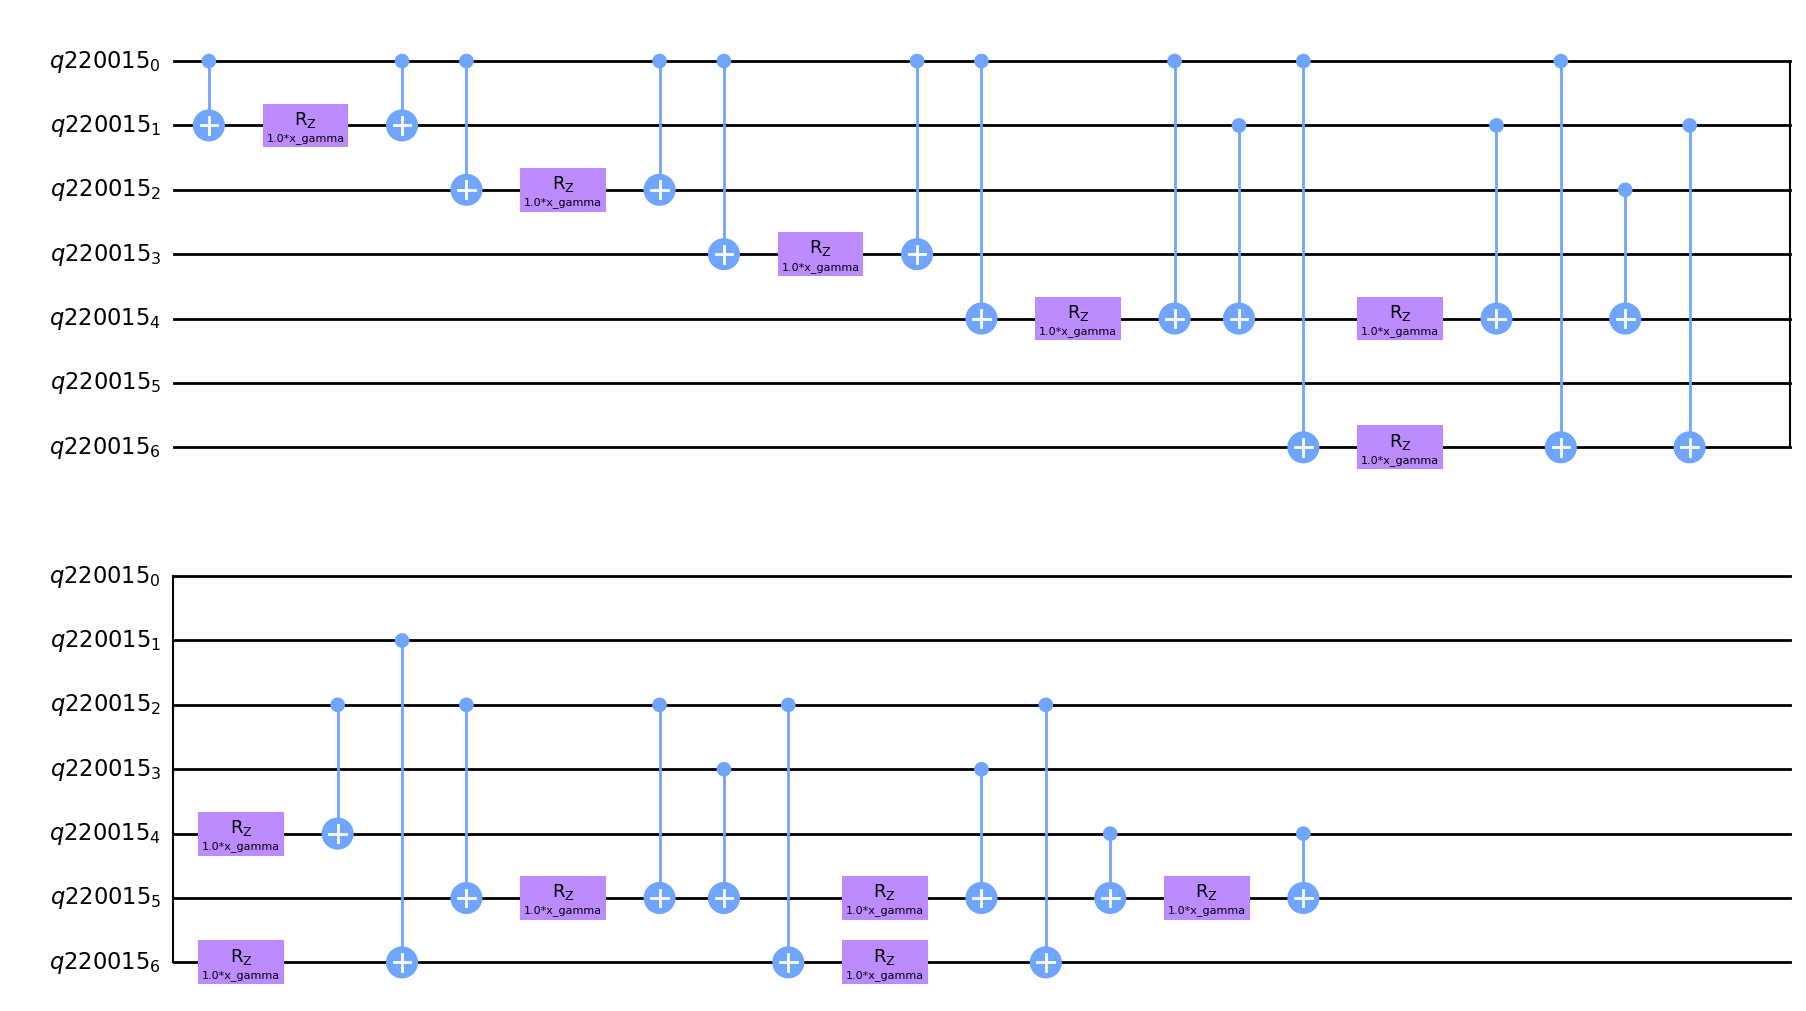

In [287]:
from qiskit.compiler import transpile
transpile(cost_circuit(G),basis_gates=['cx','rx','rz']).draw(output='mpl')

In [288]:

class My_MaxCut(Problem):
    def __init__(self, G) -> None:
        self.G = G
        self.N_qubits = self.G.number_of_nodes()

    def cost(self, string):
        return cost_string(self.G,string)

    def create_circuit(self):
        q = QuantumRegister(self.N_qubits)
        self.circuit = QuantumCircuit(q)
        self.circuit.append(cost_circuit(self.G),q)

In the MAXCUT problem the QAOA minimization is performed with respect to all states, so in particular in the whole n qubits Hilbert Space. For the standard QAOA the the mixing Hamiltonian is $H_{M}=\sum_{i=1}^{N}\sigma^{x}_{i}$ usually called X mixer. So for the Unconstrained QAOA, once we have choose the mixing Hamiltonian, we have to be able to prepare as initial state $\ket{\psi_{0}}$ in the ground state of $H_{M}$  and to be able to implement the mixing operator $U_{M}=e^{-i\beta{H_{M}}}$ in terms of the native gates.

# Exercise: Implement the X mixer operator 

In [289]:
def My_X_mixer(G):
    N_qubits=len(G.nodes)

    qr=QuantumRegister(N_qubits)
    qc=QuantumCircuit(qr,name='Mixer')

    mix_param=Parameter("beta")

    '''
    Construct the Quantum circuit that implement the X mixer here
    '''
    
    return qc

In [ ]:
'''
for i in range (0,N_qubits):
        qc.rx(mix_param,qr[i])
'''

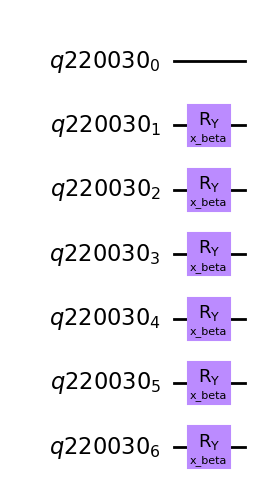

In [290]:
transpile(My_X_mixer(G),basis_gates=['cx','rx','rz','ry']).draw(output='mpl')

In [291]:
class My_X(Mixer):

    def __init__(self, G) -> None:
        self.G = G
        self.N_qubits = self.G.number_of_nodes()
        
    def create_circuit(self):
        q = QuantumRegister(self.N_qubits)

        self.circuit = QuantumCircuit(q)
        self.circuit.append(My_X_mixer(self.G),q)

# Exercise: Prepare the initial state as the ground state of the Mixing Hamiltonian 

In [292]:
def My_initial_state_circuit(G):
    N_qubits=len(G.nodes)

    qr=QuantumRegister(N_qubits)
    qc=QuantumCircuit(qr,name='initial_state')

    '''
    Construct the circuit that prepares the ground state of X mixer
    '''

    return qc

In [ ]:
'''
qc.x(qr[0])
    for i in range (0,N_qubits):
        qc.h(qr[i])
'''

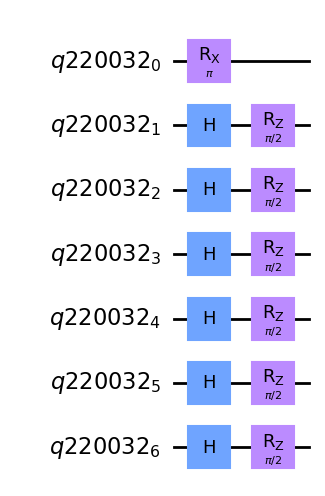

In [293]:
transpile(My_initial_state_circuit(G),basis_gates=['h','cx','rz','rx','ry']).draw(output='mpl')

In [294]:
class My_Initial_circuit(InitialState):
    def __init__(self, G) -> None:
        self.G = G
        self.N_qubits = self.G.number_of_nodes()

    def create_circuit(self):
        q = QuantumRegister(self.N_qubits)
        self.circuit = QuantumCircuit(q)
        self.circuit.append(My_initial_state_circuit(self.G),q)

Once we have defined the building blocks of our QAOA ansatz we can define an instance using the QAOA package to study the performances of the algorithm

In [295]:
qaoa = QAOA(
    initialstate=My_Initial_circuit(G), problem=My_MaxCut(G=G), mixer=My_X(G=G)
)

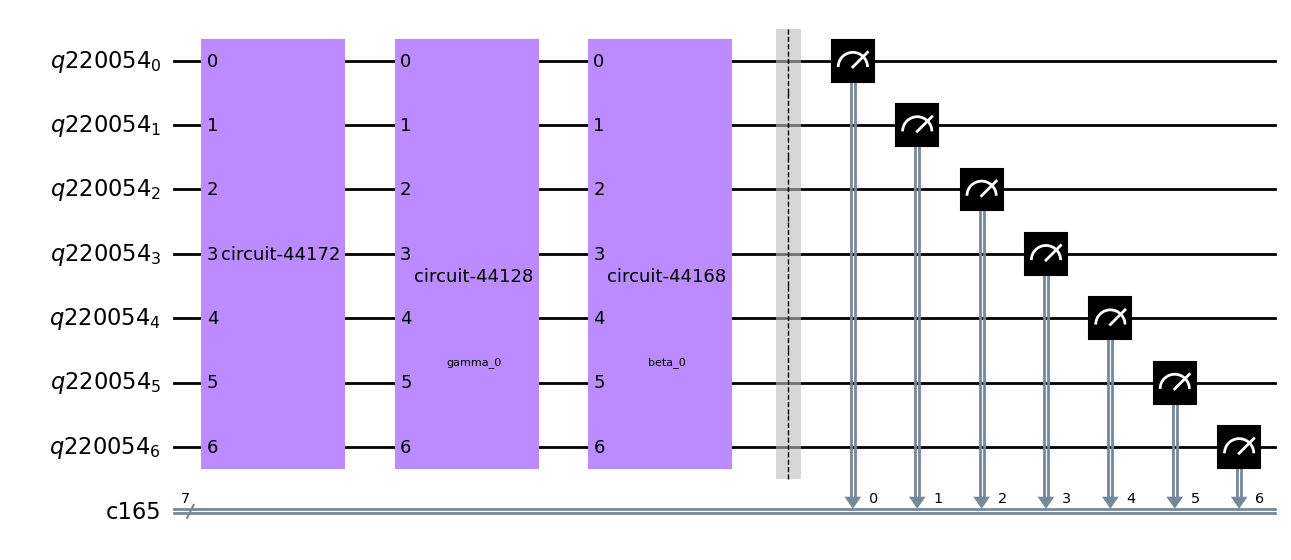

In [296]:
qaoa.createParameterizedCircuit(1)
qaoa.parameterized_circuit.draw(output="mpl")

In [297]:
def Hamiltonian_spectrum(G):
    n=len(G.nodes)
    bit_strings = [bin(i)[2:].zfill(n) for i in range(2**n)]
    result = {bit_string: cost_string(G,bit_string) for bit_string in bit_strings}
    return result

In [298]:
Hamiltonian_spectrum(G)

{'0000000': 0,
 '0000001': 3.0,
 '0000010': 3.0,
 '0000011': 6.0,
 '0000100': 4.0,
 '0000101': 7.0,
 '0000110': 5.0,
 '0000111': 8.0,
 '0001000': 2.0,
 '0001001': 5.0,
 '0001010': 3.0,
 '0001011': 6.0,
 '0001100': 6.0,
 '0001101': 9.0,
 '0001110': 5.0,
 '0001111': 8.0,
 '0010000': 4.0,
 '0010001': 5.0,
 '0010010': 5.0,
 '0010011': 6.0,
 '0010100': 6.0,
 '0010101': 7.0,
 '0010110': 5.0,
 '0010111': 6.0,
 '0011000': 6.0,
 '0011001': 7.0,
 '0011010': 5.0,
 '0011011': 6.0,
 '0011100': 8.0,
 '0011101': 9.0,
 '0011110': 5.0,
 '0011111': 6.0,
 '0100000': 3.0,
 '0100001': 4.0,
 '0100010': 6.0,
 '0100011': 7.0,
 '0100100': 5.0,
 '0100101': 6.0,
 '0100110': 6.0,
 '0100111': 7.0,
 '0101000': 5.0,
 '0101001': 6.0,
 '0101010': 6.0,
 '0101011': 7.0,
 '0101100': 7.0,
 '0101101': 8.0,
 '0101110': 6.0,
 '0101111': 7.0,
 '0110000': 7.0,
 '0110001': 6.0,
 '0110010': 8.0,
 '0110011': 7.0,
 '0110100': 7.0,
 '0110101': 6.0,
 '0110110': 6.0,
 '0110111': 5.0,
 '0111000': 9.0,
 '0111001': 8.0,
 '0111010': 8.0,

For the case p=1 we can plot how the energy landscape looks like. This can help us to understand better how the optimization routine works. The energy landscape can be obtain just evaluating the energy associated to a certain couples of values $\gamma,\beta$ in a certain range. We know from construction that the energy in periodic in $\beta$ between $[0,2\pi]$ and we want to explore the same range of values for the $\gamma$ parameter.

In the following cell we are going to plot the heatmap related to:

$\bra{\gamma,\beta}H\ket{\gamma,\beta}$, $\gamma,\beta\in[0,2\pi]$

2023-10-16 11:54:14 [info     ] Calculating energy landscape for depth p=1... file=qaoa.qaoa func=sample_cost_landscape
1 0
2023-10-16 11:54:14 [info     ] Executing sample_cost_landscape file=qaoa.qaoa func=sample_cost_landscape
2023-10-16 11:54:14 [info     ] parameters: 2                  file=qaoa.qaoa func=sample_cost_landscape
2023-10-16 11:54:14 [info     ] Done execute                   file=qaoa.qaoa func=sample_cost_landscape
2023-10-16 11:54:14 [info     ] Done measurement               file=qaoa.qaoa func=sample_cost_landscape
2023-10-16 11:54:14 [info     ] Calculating Energy landscape done file=qaoa.qaoa func=sample_cost_landscape


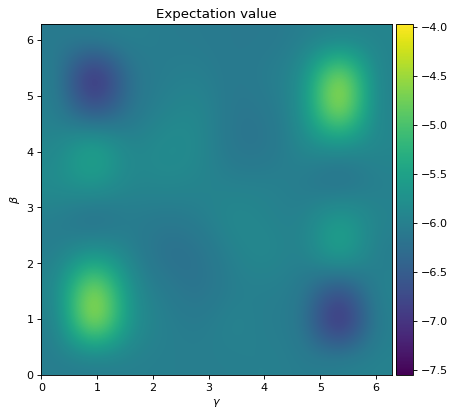

In [299]:
qaoa.sample_cost_landscape(
    angles={"gamma": [0, 2*np.pi , 50], "beta": [0, 2*np.pi, 50]}
)
plot_E(qaoa)

Calling the method optimize we can see how the optimization prodecure perform on the first layer of QAOA and understand from the plot of the landscape how we converge in one local minima

In [300]:
qaoa.optimize(depth=1)

2023-10-16 11:54:15 [info     ] cost(depth 1 = -7.533203125000001 file=qaoa.qaoa func=optimize


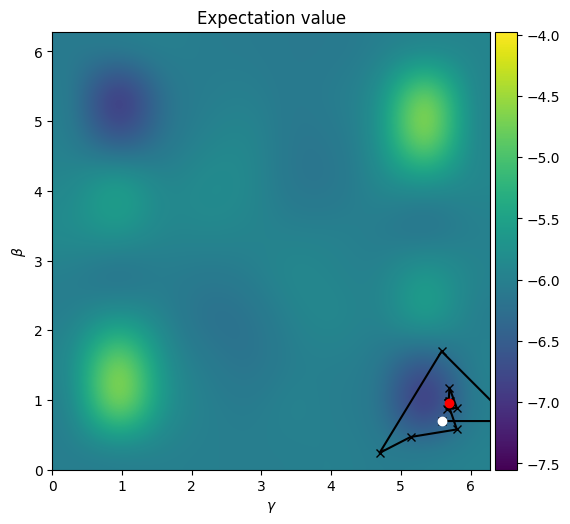

In [301]:
fig = pl.figure(figsize=(6, 6))
gamma = []
beta = []
angles = qaoa.optimization_results[1].angles
for i in range(len(angles)):
    gamma.append(angles[i][0])
    beta.append(angles[i][1])
pl.plot(gamma, beta, "x-k")
pl.plot(gamma[0], beta[0], "wo")
pl.plot(gamma[-1], beta[-1], "or")
plot_E(qaoa, fig=fig)

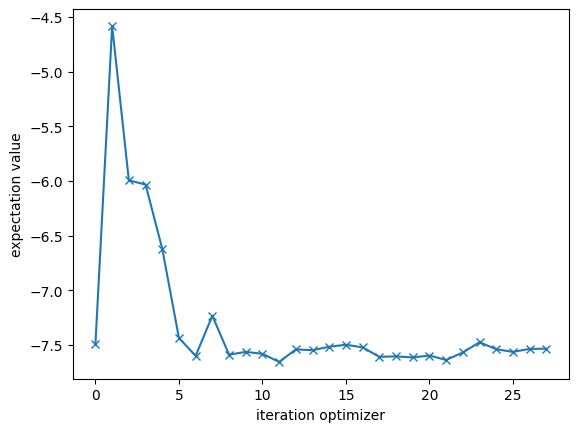

In [302]:
pl.plot(qaoa.optimization_results[1].Exp, "x-")
_ = pl.ylabel("expectation value")
_ = pl.xlabel("iteration optimizer")

In [303]:
min,max=qaoa.problem.computeMinMaxCosts()
print(min,max)

-9.0 0


# Classical Optimizer Analysis

One the most important ingredients of the QAOA algorithm, after the ansatz definition, is the choice of the classical optimizer to use to optimize the parameters at every iteration. Different types of optimizers can be used to optimize the cost function but there are three types in principle:

The Analitical gradients optimizers as the Gradient Descent 

The Stochastic Gradient Optimizers as The QNSPSA

The Gradient Free optimizers as COBYLA

In [304]:
from qiskit_algorithms.optimizers import QNSPSA,COBYLA,GradientDescent

In [305]:
optimizers = {}
plotstyle = {}


settings = {"maxiter": 100, "tol": 1e-6,"learning_rate": 0.1}
optimizers["gradient"] = [GradientDescent, settings.copy()]
plotstyle["gradient"] = "og"

settings = {
    "maxiter": 50,
    "blocking": True,
    "allowed_increase": 0,
    "learning_rate": 0.02,
    "perturbation": 0.05,
    "regularization": 0.01,
    "hessian_delay": 0,
}
optimizers["qnspsa"] = [QNSPSA, settings.copy()]
plotstyle["qnspsa"] = "og"


settings = {"maxiter": 100, "tol": 1e-6}
optimizers["cobyla"] = [COBYLA, settings.copy()]
plotstyle["cobyla"] = "*k"



In [306]:
qaoa = {}
for key in optimizers:
    qaoa[key] = QAOA(
        initialstate=My_initial_state_circuit(G),
        problem=MaxCut(G),
        mixer=X(G),
        optimizer=optimizers[key],
    )

In [307]:
maxdepth = 6
for key in optimizers:
    qaoa[key].optimize(depth=maxdepth)

2023-10-16 11:54:15 [info     ] Calculating energy landscape for depth p=1... file=qaoa.qaoa func=sample_cost_landscape
1 0
2023-10-16 11:54:15 [info     ] Executing sample_cost_landscape file=qaoa.qaoa func=sample_cost_landscape
2023-10-16 11:54:15 [info     ] parameters: 2                  file=qaoa.qaoa func=sample_cost_landscape
2023-10-16 11:54:15 [info     ] Done execute                   file=qaoa.qaoa func=sample_cost_landscape
2023-10-16 11:54:17 [info     ] Done measurement               file=qaoa.qaoa func=sample_cost_landscape
2023-10-16 11:54:17 [info     ] Calculating Energy landscape done file=qaoa.qaoa func=sample_cost_landscape
2023-10-16 11:54:24 [info     ] cost(depth 1 = -7.5693359375   file=qaoa.qaoa func=optimize
2023-10-16 11:54:34 [info     ] cost(depth 2 = -8.000976562500002 file=qaoa.qaoa func=optimize
2023-10-16 11:54:48 [info     ] cost(depth 3 = -8.2763671875   file=qaoa.qaoa func=optimize
2023-10-16 11:55:07 [info     ] cost(depth 4 = -8.635742187499998 fi

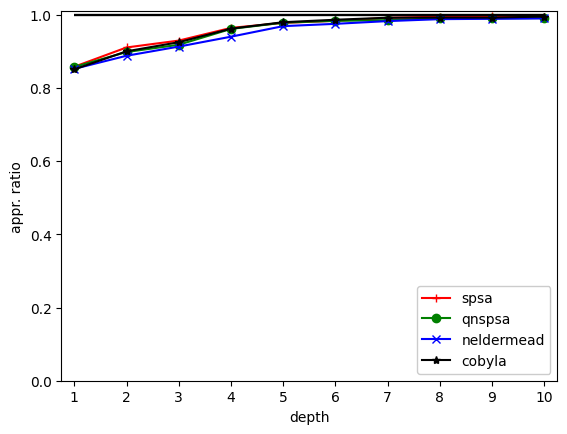

In [308]:
fig = pl.figure()
for key in optimizers:
    plot_ApproximationRatio(
        qaoa[key],
        maxdepth,
        mincost=min,
        maxcost=max,
        label=key,
        style=plotstyle[key] + "-",
        fig=fig,
    )

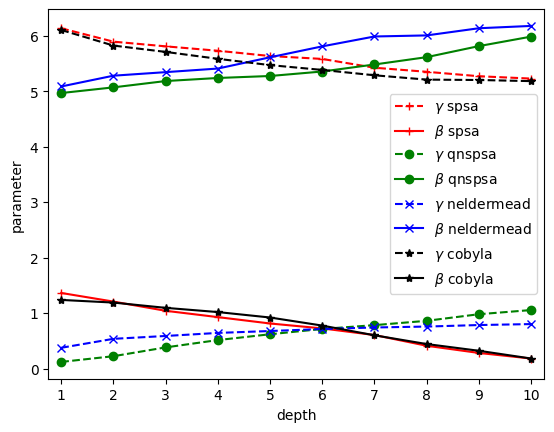

In [309]:
p = maxdepth
fig = pl.figure(p)

for key in optimizers:
    plot_angles(qaoa[key], p, label=key, style=plotstyle[key], fig=fig)

(0.0, 100.0)

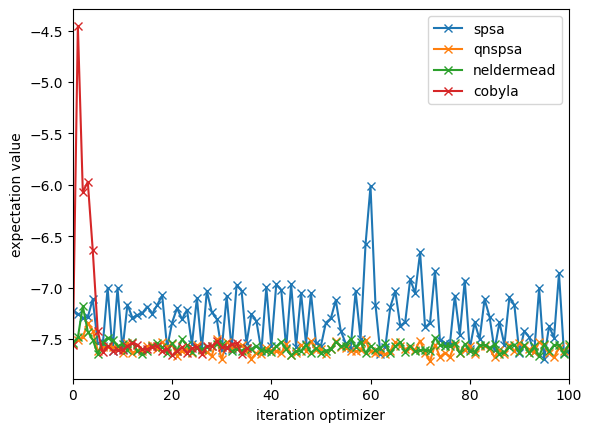

In [310]:
for key in optimizers:
    pl.plot(qaoa[key].optimization_results[1].Exp, "x-",label=key)
_ = pl.ylabel("expectation value")
_ = pl.xlabel("iteration optimizer")
pl.legend()
pl.xlim(0,100)

(0.0, 100.0)

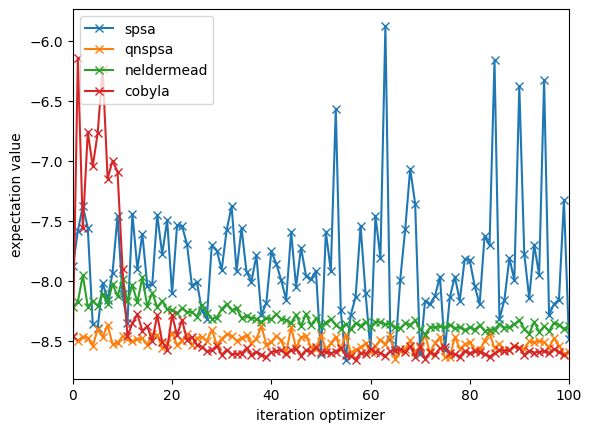

In [311]:
for key in optimizers:
    pl.plot(qaoa[key].optimization_results[4].Exp, "x-",label=key)
_ = pl.ylabel("expectation value")
_ = pl.xlabel("iteration optimizer")
pl.legend()
pl.xlim(0,100)

# Exercise: Implement the Y Mixer and the new initial state 


In [ ]:
def My_Y_mixer(G):
    N_qubits=len(G.nodes)

    qr=QuantumRegister(N_qubits)
    qc=QuantumCircuit(qr,name='Y_Mixer')

    mix_param=Parameter("beta")

    '''
    Construct the Quantum circuit that implement the Y mixer here
    '''
    
    return qc

In [ ]:
class My_Y(Mixer):

    def __init__(self, G) -> None:
        self.G = G
        self.N_qubits = self.G.number_of_nodes()
        
    def create_circuit(self):
        q = QuantumRegister(self.N_qubits)

        self.circuit = QuantumCircuit(q)
        self.circuit.append(My_X_mixer(self.G),q)

In [ ]:
def My_Y_initial_state_circuit(G):
    N_qubits=len(G.nodes)

    qr=QuantumRegister(N_qubits)
    qc=QuantumCircuit(qr,name='Y_initial_state')

    '''
    Construct the circuit that prepares the ground state of Y mixer
    '''

    return qc

In [ ]:
class My_Y_Initial_circuit(InitialState):
    def __init__(self, G) -> None:
        self.G = G
        self.N_qubits = self.G.number_of_nodes()

    def create_circuit(self):
        q = QuantumRegister(self.N_qubits)
        self.circuit = QuantumCircuit(q)
        self.circuit.append(My_Y_initial_state_circuit(self.G),q)

In [ ]:
qaoa_y = QAOA(
    initialstate=My_Y_Initial_circuit(G), problem=My_MaxCut(G=G), mixer=My_Y(G=G)
)
qaoa_y.sample_cost_landscape(
    angles={"gamma": [0, 2*np.pi , 50], "beta": [0, 2*np.pi, 50]}
)
plot_E(qaoa)

In [ ]:
qaoa_y.optimize(depth=maxdepth)
plot_ApproximationRatio(
        qaoa_y,
        maxdepth,
        mincost=min,
        maxcost=max,
        label=key,
        style=plotstyle + "-",
        fig=fig,
    )

# Exercise: How the performance change if I choose state Different than the ground state? In this exercise we want to study the performance of the qaoa in function of the overlap with the ground state of the x mixer 

Create a circuit that prepares as initial state $\ket{\psi_{0}(\theta)}=\Pi_{i}^{n}R_{y}^{i}(\theta)\ket{0}=(cos(\frac{\theta}{2})\ket{0}+sin(\frac{\theta}{2})\ket{1})^{\otimes n}$

In [ ]:
def Parametric_initial_state_circuit(G,theta):
    N_qubits=len(G.nodes)

    qr=QuantumRegister(N_qubits)
    qc=QuantumCircuit(qr,name='Y_initial_state')

    '''
    Construct the circuit that prepares the initial state in function of theta
    '''

    return qc

In [ ]:
class My_parametric_Initial_circuit(InitialState):
    def __init__(self, G) -> None:
        self.G = G
        self.N_qubits = self.G.number_of_nodes()

    def create_circuit(self):
        q = QuantumRegister(self.N_qubits)
        self.circuit = QuantumCircuit(q)
        self.circuit.append(Parametric_initial_state_circuit(self.G,theta),q)

Construct a function that evaluates the overlap between this new initial state and the ground state of the X mixer depending of $\theta$ 

$f(\theta)=|\bra{\psi_{0}(\theta)}\ket{+}^{\otimes n}|^{2}$

In [ ]:
def Overlap_ground_state(theta):
    f=0

    return f

Compute now the performance of the QAOA with depth 1 using different 6 theta values in the range $[0,\pi]$

# Exercise: Use the Symmetry of the Problem to reduce the number of qubits necessary 

In [ ]:
def reduced_cost_string(G):
    return

def reduced_cost_circuit(G):
    return 

In [312]:
class Reduced_MaxCut(Problem):
    def __init__(self, G) -> None:
        self.G = G
        self.N_qubits = self.G.number_of_nodes()-1

    def cost(self, string):
        return reduced_cost_string(self.G,string)

    def create_circuit(self):
        q = QuantumRegister(self.N_qubits)
        self.circuit = QuantumCircuit(q)
        self.circuit.append(reduced_cost_circuit(self.G),q)